In [2]:
  # # # # # # # # # # # # # # # # # # # # # # # # # #
 #                                                   #
#   Description: Script to calibrate TMDB boards      #
#                                                     #
#   Author: Melissa Aguiar                            #
#                                                     #
#   Created: Aug. 05, 2022                            #
 #                                                   #
  # # # # # # # # # # # # # # # # # # # # # # # # # #

import numpy as np
from sklearn.covariance import MinCovDet
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def robust_cov(A):
    """
    Returns the robust estimator of the covariance for matrix A

    """

    robust_cov = MinCovDet().fit(A.T).covariance_

    return robust_cov


In [3]:
run_number = "451896"
run_number_PED = "440716"
pack = 0
input_path = "files/files_" + run_number
plots_path = "../plots/plots_" + run_number + "_robust_cov"
n_muons_file = "1000"
n_muons = 600

print("loading data...")

sampleZB   = np.concatenate((np.load('files/files_427892/sampleZB_427892_0.npy'), np.load('files/files_427892/sampleZB_427892_1.npy')),axis=0)
#sampleZB   = np.load('files/files_427892/sampleZB_427892_0.npy')
sampleMuon = np.load('../files/muons4peak_' + run_number + '/sampleMuon' + n_muons_file + '_' + run_number + '.npy')
eOptMuon   = np.load('../files/muons4peak_' + run_number + '/eOptMuon' + n_muons_file + '_' + run_number + '.npy')
pedestal_data = np.load('files/files_' + run_number_PED + '/eOptPED' + '_' + run_number_PED + '_' + str(pack) + '.npy')

sampleMuon = sampleMuon[0:n_muons]
eOptMuon   = eOptMuon[0:n_muons]

print("SampleZB shape:      ", sampleZB.shape)
print("SampleMuon shape:    ", sampleMuon.shape)
print("eOptMuon shape:      ", eOptMuon.shape)
print("pedestal_data shape: ", pedestal_data.shape)

print("done!")

loading data...
SampleZB shape:       (100000, 4, 64, 8, 7)
SampleMuon shape:     (600, 4, 64, 8, 7)
eOptMuon shape:       (600, 4, 64, 8, 1)
pedestal_data shape:  (200, 4, 64, 8)
done!


In [3]:
plotting = 1

In [4]:
sides               = 4                             # Number of sides (EBA, EBC, LBA, LBC)
modules             = 64                            # Number of TileCal modules
cells_tmdb          = 8                             # Number of TMDB cells
cells_tile          = 48                            # Number of Tilecal cells
cells_in_use        = 4                             # Number of cells in use (D5R, D5L, D6R, D6L)
pulses              = 7                             # Number of samples for each pulse
pulses_axis         = range(1, 8)                   # Axis for plotting pulses

limit_min   = 600                                   # Minimum energy limit [MeV]
limit_max   = 5000                                  # Maximum energy limit [MeV]
entries     = 50000                                 # Number of entries to process
threshold   = 500                                   # Energy value [MeV] to fit with quantized sample

cells_map   = {0: 17, 1: 16, 2: 37, 3: 38}          # Mapping cells from TMDB to Tilecal
channel     = {0: 'D5L', 1:'D5R', 2:'D6L', 3:'D6R'} # Channels name
sides_map   = {2:'EBA', 3:'EBC'}                    # Mapping sides for TMDB
events_map  = range(0, np.size(sampleMuon, 0))      # Mapping events
pulses_map  = range(0, pulses)                      # Mapping pulses
mods_map    = range(0, modules)                     # Mapping modules

samples_ped = np.zeros((np.size(sampleMuon, 0), sides, modules, cells_in_use, pulses))

C           = np.zeros((sides, modules, cells_in_use, pulses, pulses))
C_inv       = np.zeros((sides, modules, cells_in_use, pulses, pulses))

mean_pulse  = np.zeros((sides, modules, cells_in_use, pulses))
norm_pulse  = np.zeros((sides, modules, cells_in_use, pulses))
pedestal    = np.zeros((sides, modules, cells_in_use, pulses))
w           = np.zeros((sides, modules, cells_in_use, pulses))
quant_w     = np.zeros((sides, modules, cells_in_use, pulses))

old_std     = np.zeros((sides, modules, cells_in_use, 7))
new_std     = np.zeros((sides, modules, cells_in_use, 7))
std_relat   = np.zeros((sides, modules,               7)) # D5R, D5L, D6R, D6L, D5, D6 and D5+D6
e500        = np.zeros((sides, modules, cells_in_use, 1))
coefit      = np.zeros((sides, modules, cells_in_use, 2))

os.system("mkdir ../data")
os.system("mkdir ../data/data_" + run_number)

os.system("mkdir ../plots")
os.system("mkdir " + plots_path)
os.system("mkdir " + plots_path +     "/all_modules")
os.system("mkdir " + plots_path +        "/pedestal")
os.system("mkdir " + plots_path +      "/covariance")
os.system("mkdir " + plots_path +  "/covariance_inv")
os.system("mkdir " + plots_path +             "/fit")
os.system("mkdir " + plots_path +      "/mean_pulse")
os.system("mkdir " + plots_path + "/mean_pulse_norm")
os.system("mkdir " + plots_path +         "/samples")
os.system("mkdir " + plots_path +         "/weights")

for sd in sides_map:
    for md in mods_map:
        os.system("mkdir " + plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}")

mkdir: cannot create directory ‘../data’: File exists
mkdir: cannot create directory ‘../data/data_451896’: File exists
mkdir: cannot create directory ‘../plots’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/pedestal’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/covariance’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/covariance_inv’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/fit’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/mean_pulse’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/mean_pulse_norm’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/samples’: File exists
mkdir: cannot create directo

mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC16’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC17’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC18’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC19’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC20’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC21’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC22’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC23’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC24’: File exists
mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/all_modules/EBC25’: File exists
mkdir: cannot create directory

In [7]:
############# cell off EBC58################ 
# sampleMuon[:,3,57,:,:] = 1
pedestal[3, 57, :, :] = 0
# sampleMuon[:,3,5,:,:] = 1
pedestal[3, 5, 2, :] = 0
# sampleMuon[:,3,57,:,:] = 1
pedestal[3, 57, :, :] = 0
# sampleMuon[:,3,57,:,:] = 1
pedestal[3, 57, :, :] = 0


for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            for i in pulses_map:
                pedestal[sd, md, ch, i] = np.mean(sampleZB[:, sd, md, ch, i])

for evt in events_map:
    for sd in sides_map:
        for md in mods_map:
            for ch in cells_map:
                samples_ped[evt,sd,md,ch,:] = sampleMuon[evt,sd,md,ch,:] - pedestal[sd, md, ch, :]
                for i in pulses_map:
                    mean_pulse[sd,md,ch,i]  = np.mean([samples_ped[:,sd,md,ch,i]])


for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            for i in pulses_map:
                norm_pulse[sd,md,ch,i] = mean_pulse[sd,md,ch,i]/np.max(mean_pulse[sd,md,ch,:])

In [6]:
if plotting == 1:
    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                plt.subplot(2,2,ch+1)
                plt.grid()
                plt.plot(pulses_axis, pedestal[sd, md, ch, :], '-x')
                plt.title("Pedestal | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
                plt.xlabel("Sample")
                plt.ylabel("Amplitude [ADC]")
            output_path = plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path  + "/"             + sides_map.get(sd) + f"{md+1:02}" + "_pedestal.jpeg")
            plt.savefig(plots_path   + "/pedestal/"    + sides_map.get(sd) + f"{md+1:02}" + "_pedestal.jpeg")
            plt.close()


    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                for i in range(0, np.size(samples_ped, 0)):
                    plt.subplot(2,2,ch+1)
                    plt.plot(pulses_axis, samples_ped[i,sd, md, ch, :])
                plt.title("Muon samples without pedestal | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch) + " | Number of events: " + str(np.size(samples_ped, 0)))
                plt.xlabel("Sample")
                plt.ylabel("Amplitude [ADC]")
                plt.grid()
            output_path = plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path  + "/"             + sides_map.get(sd) + f"{md+1:02}" + "_samples.jpeg")
            plt.savefig(plots_path   + "/samples/"     + sides_map.get(sd) + f"{md+1:02}" + "_samples.jpeg")
            plt.close()


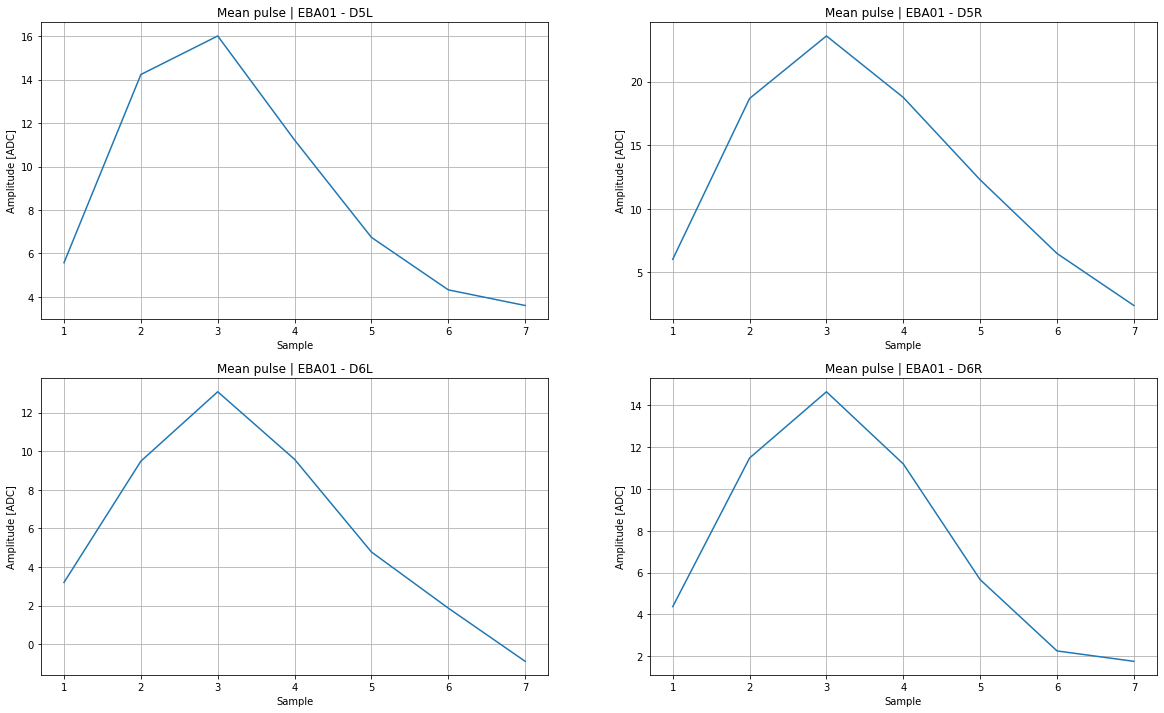

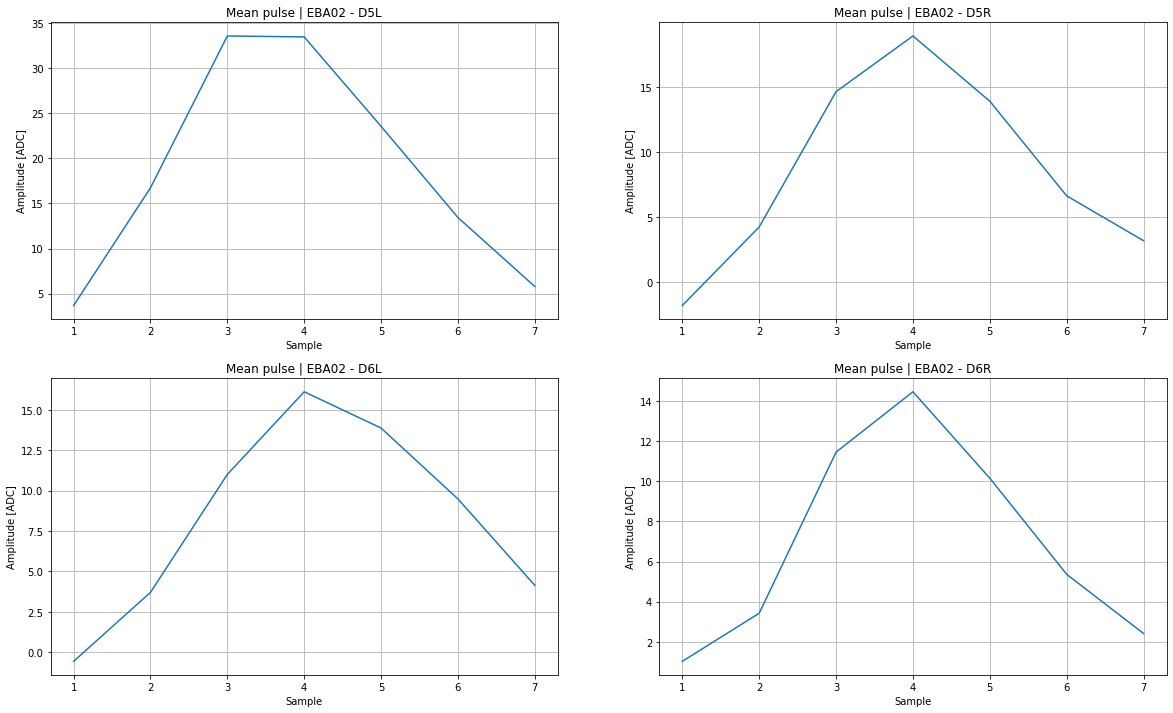

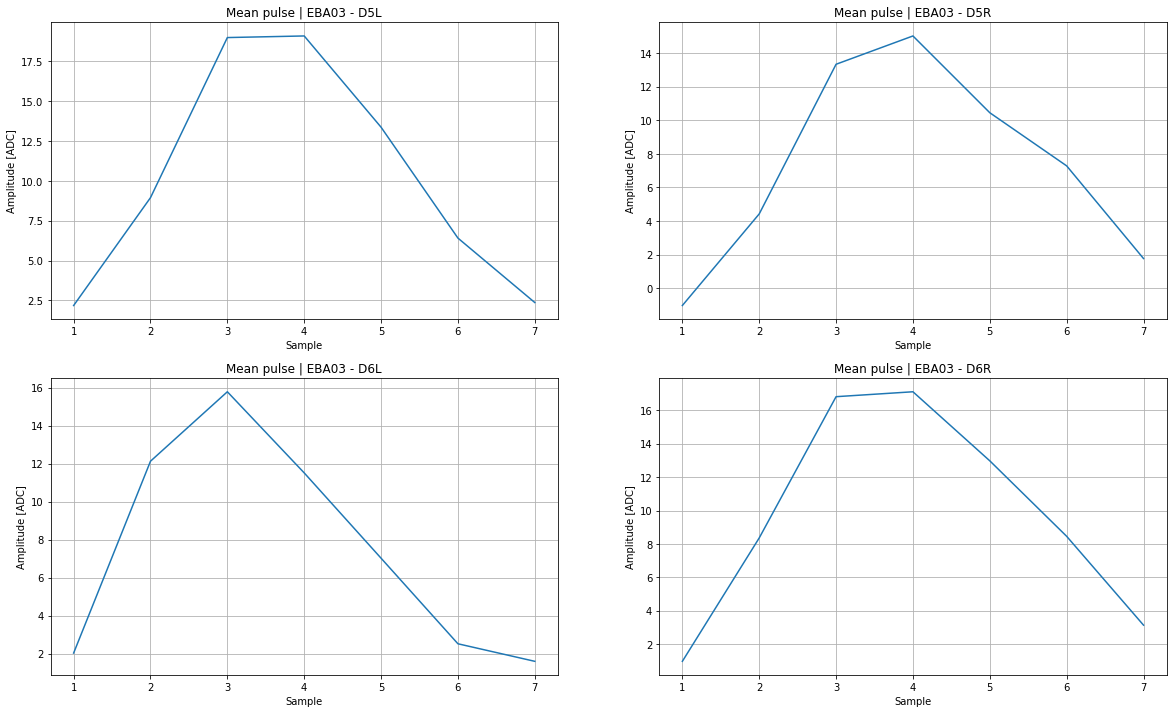

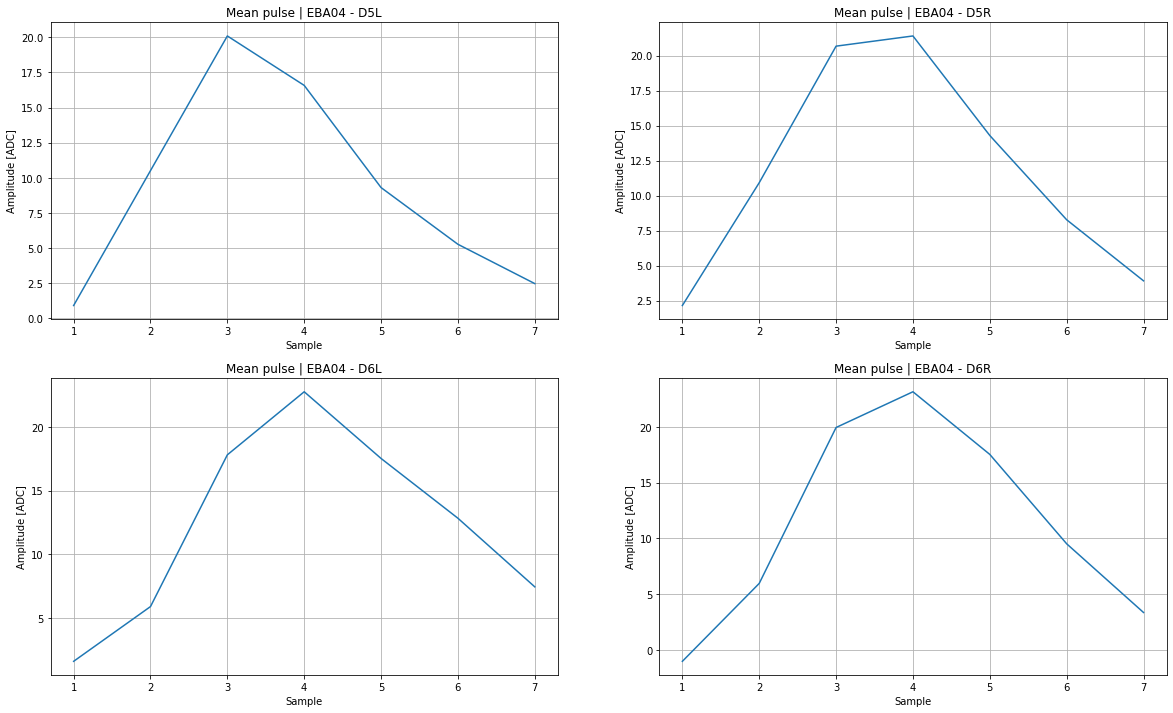

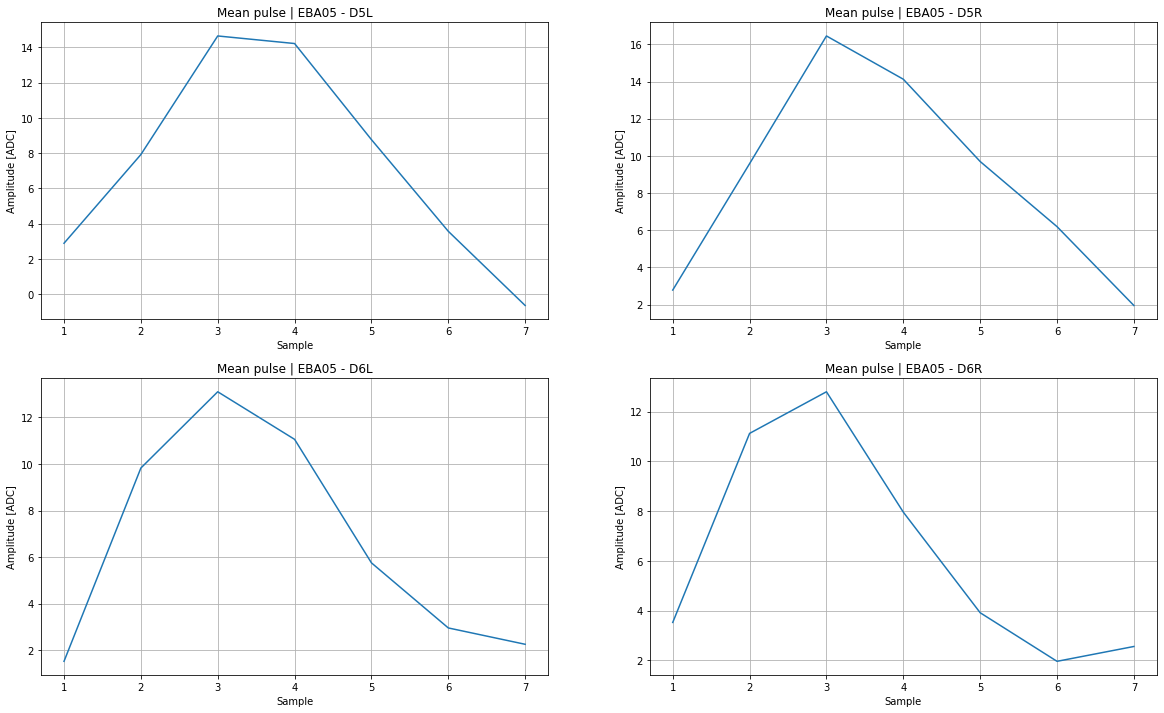

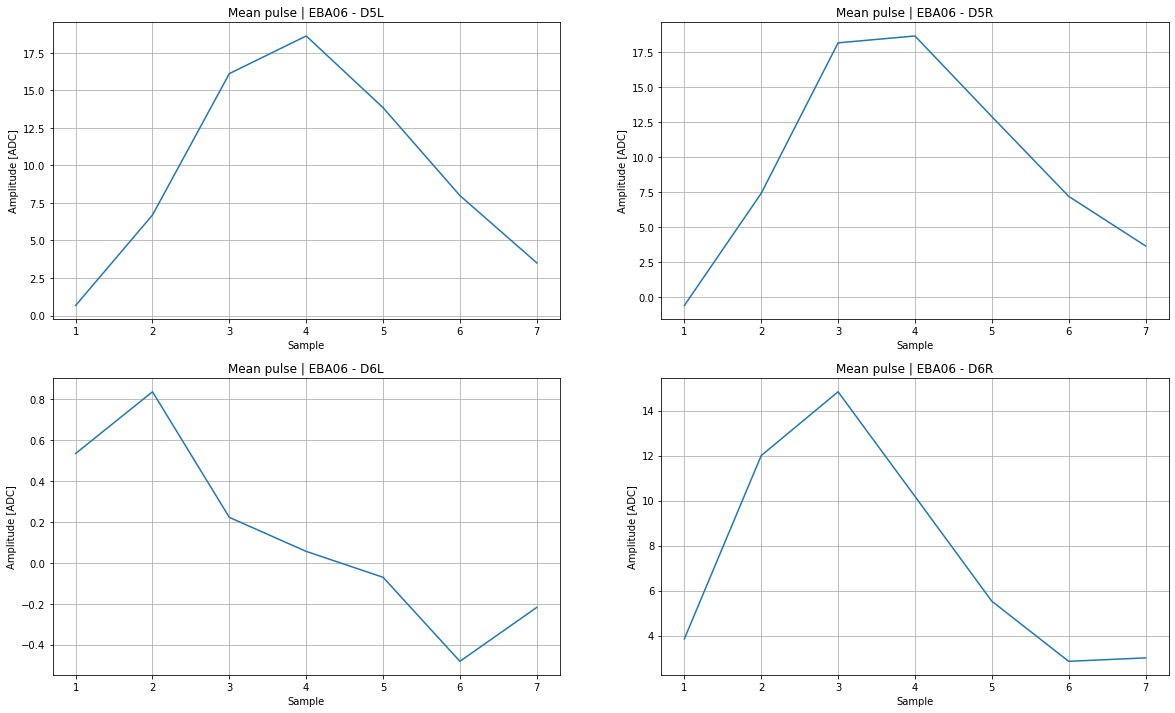

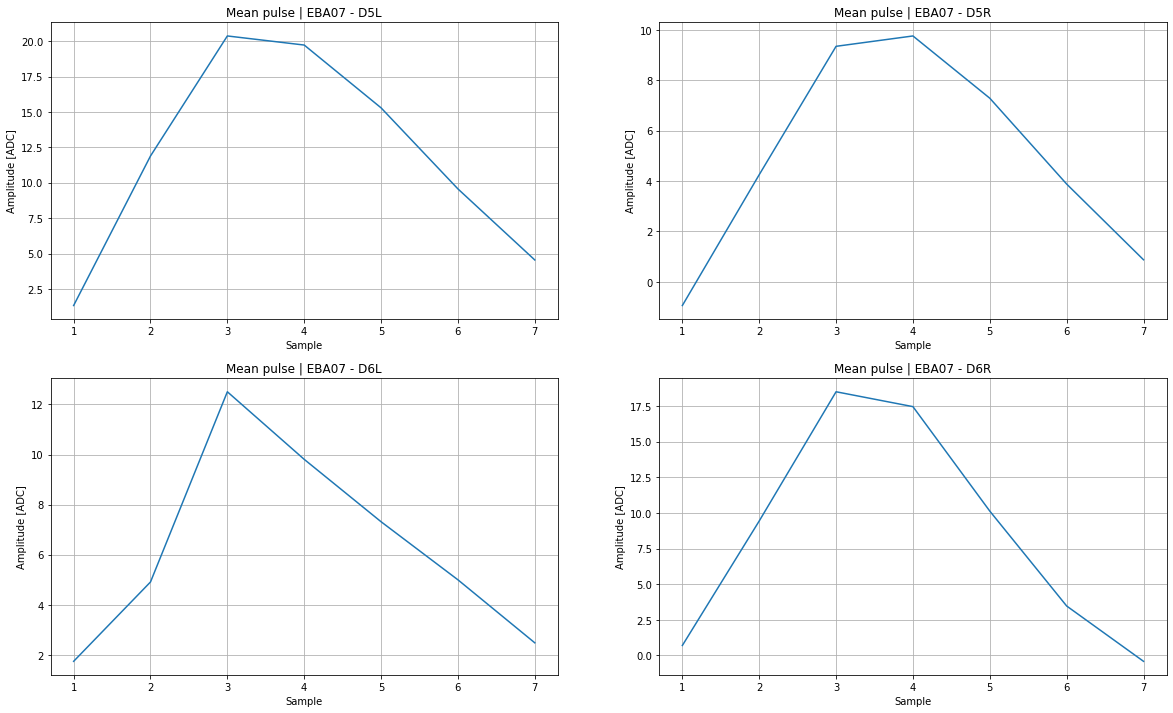

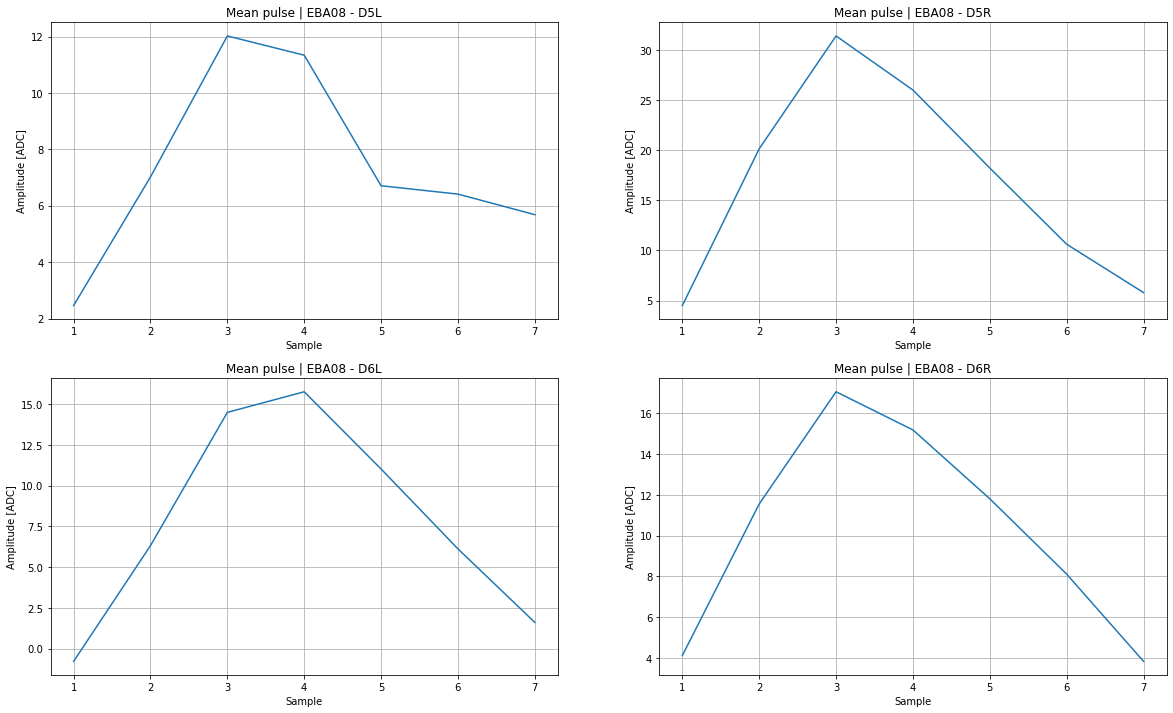

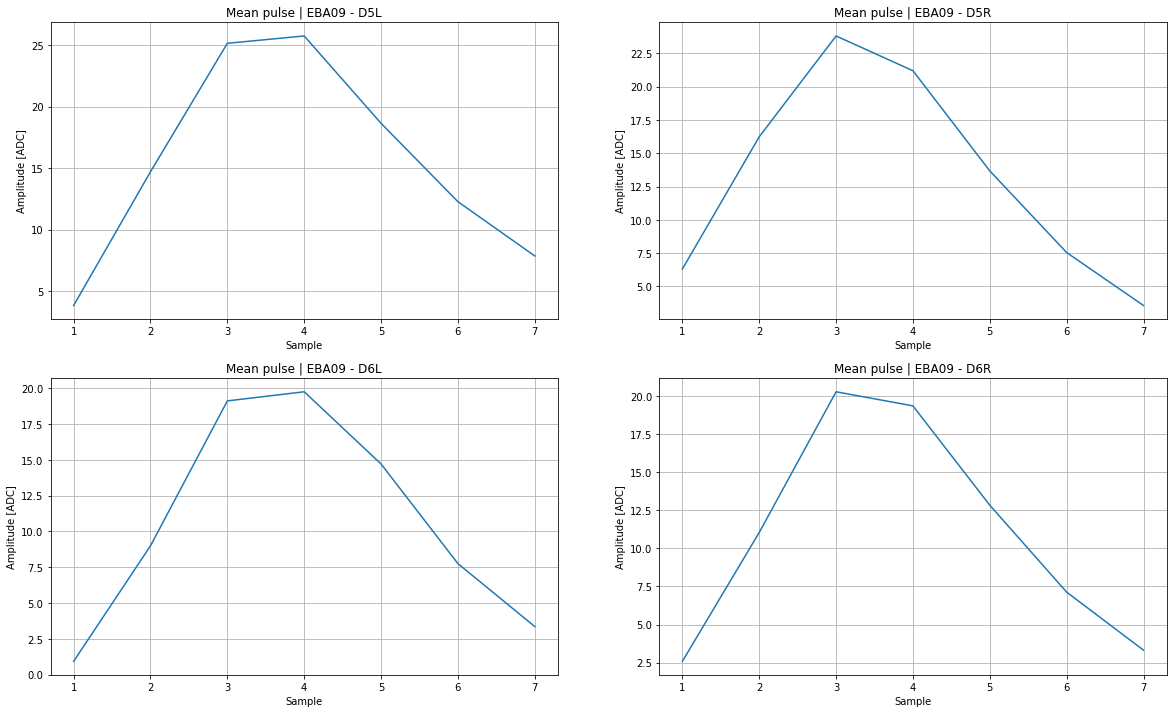

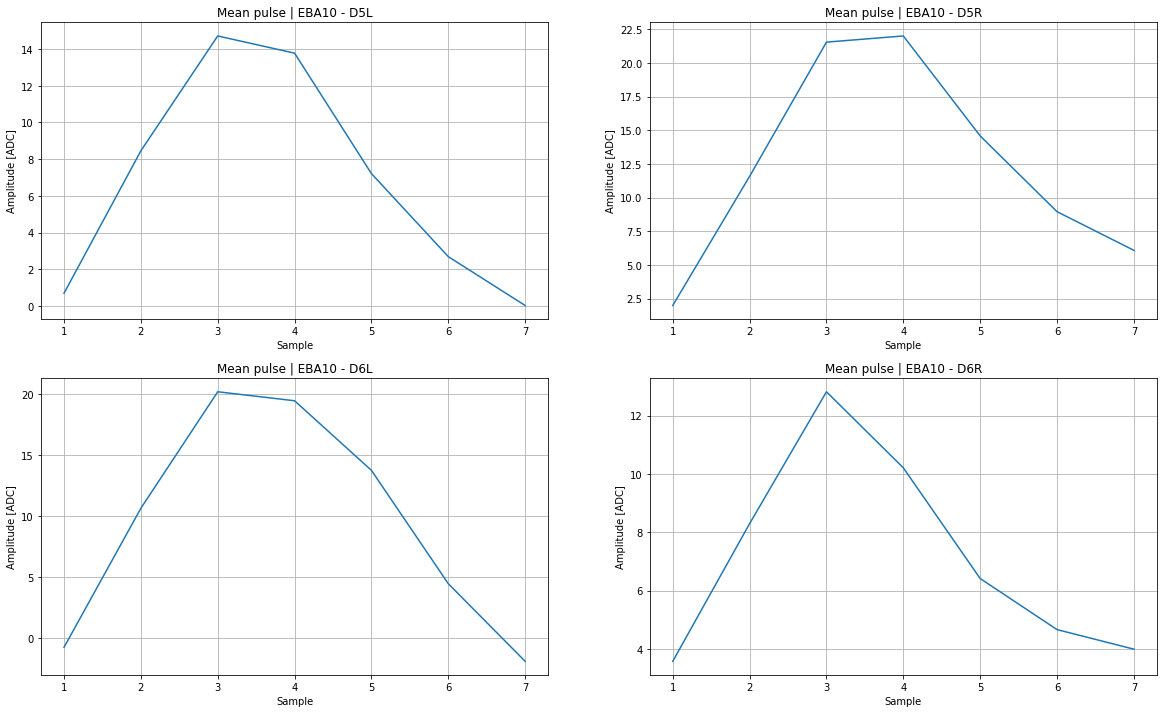

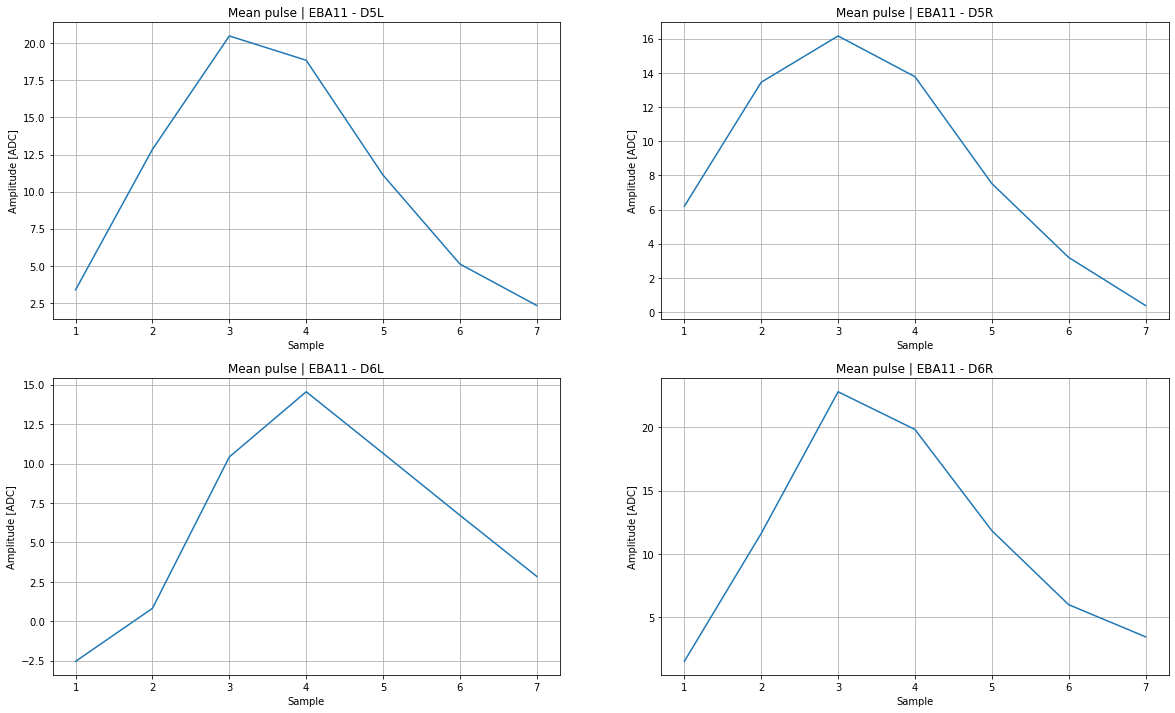

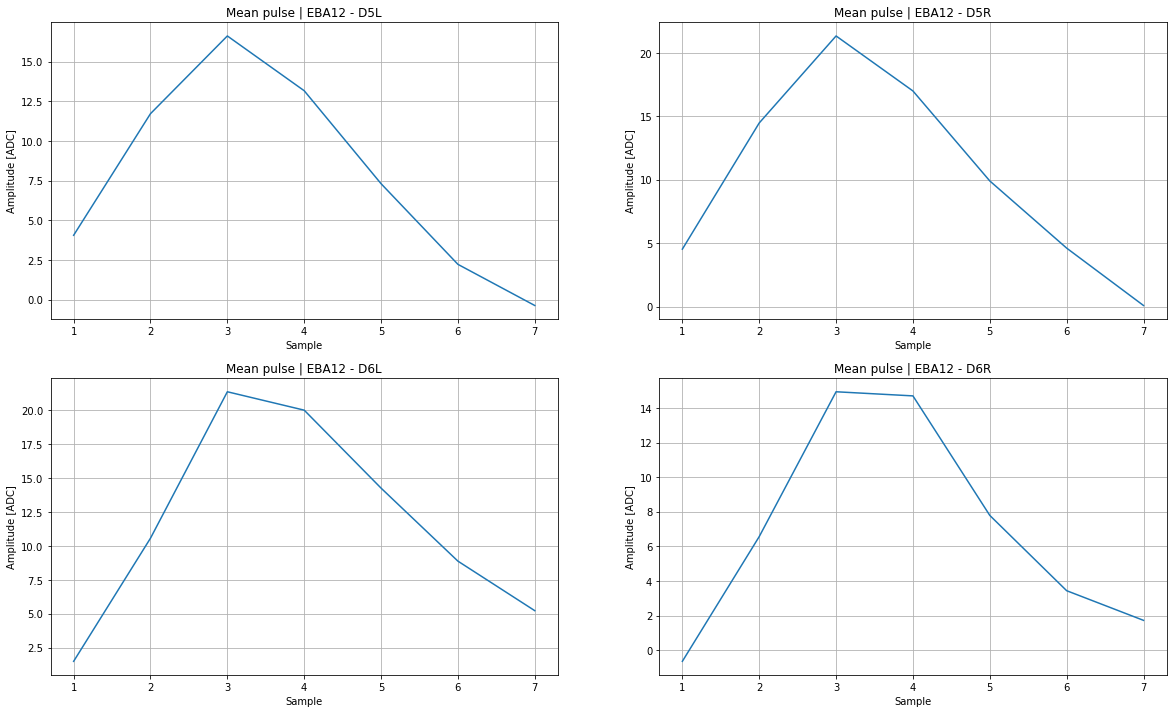

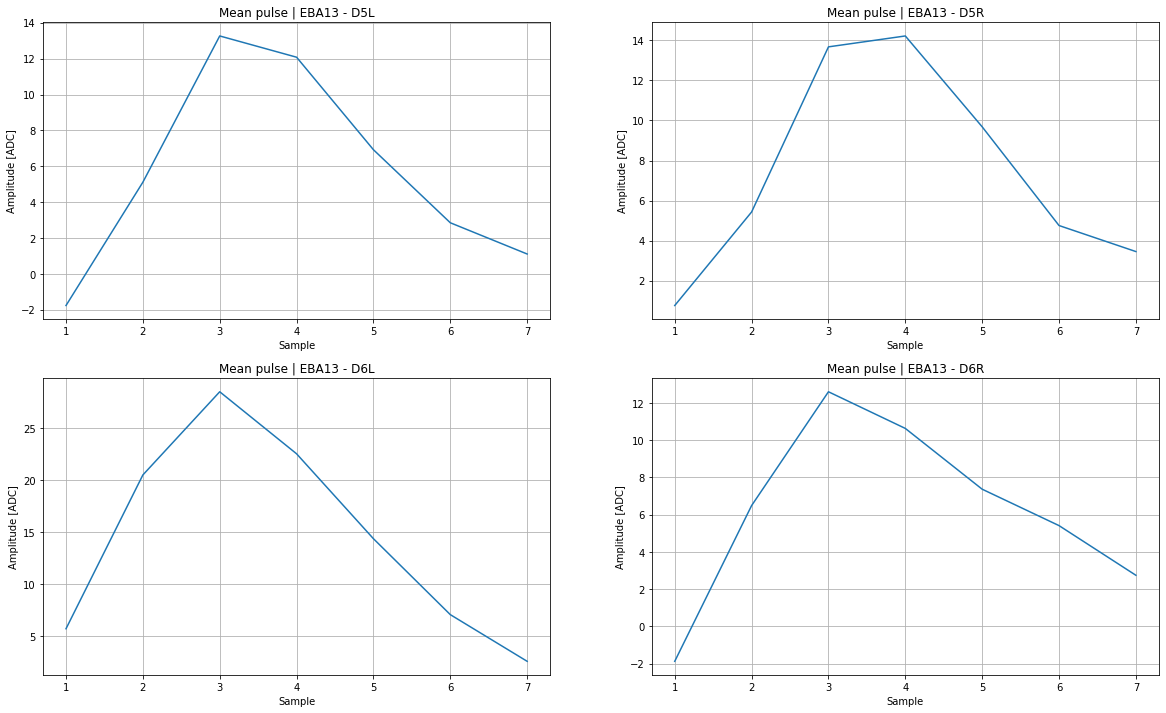

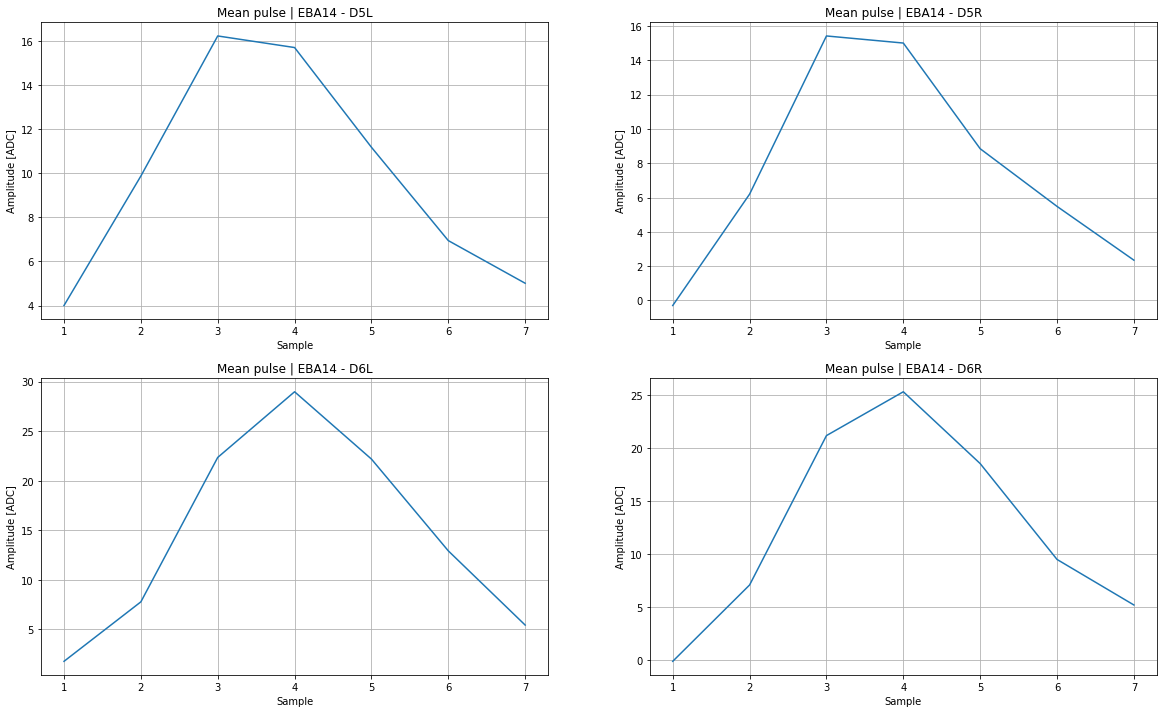

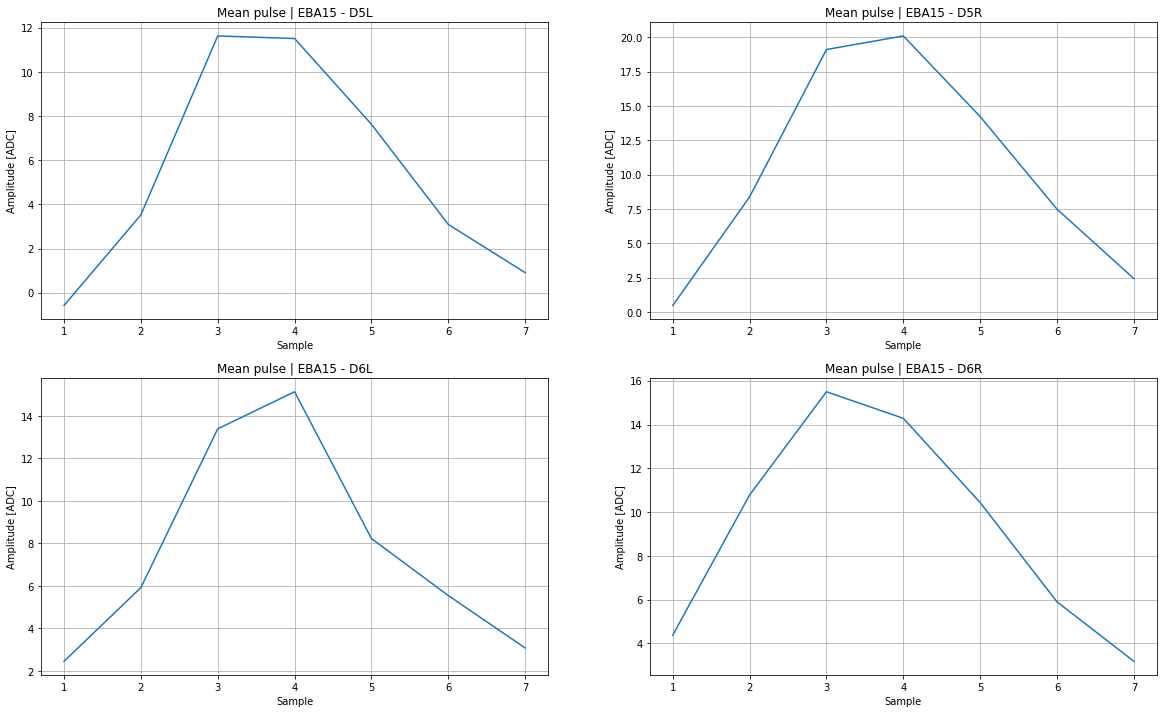

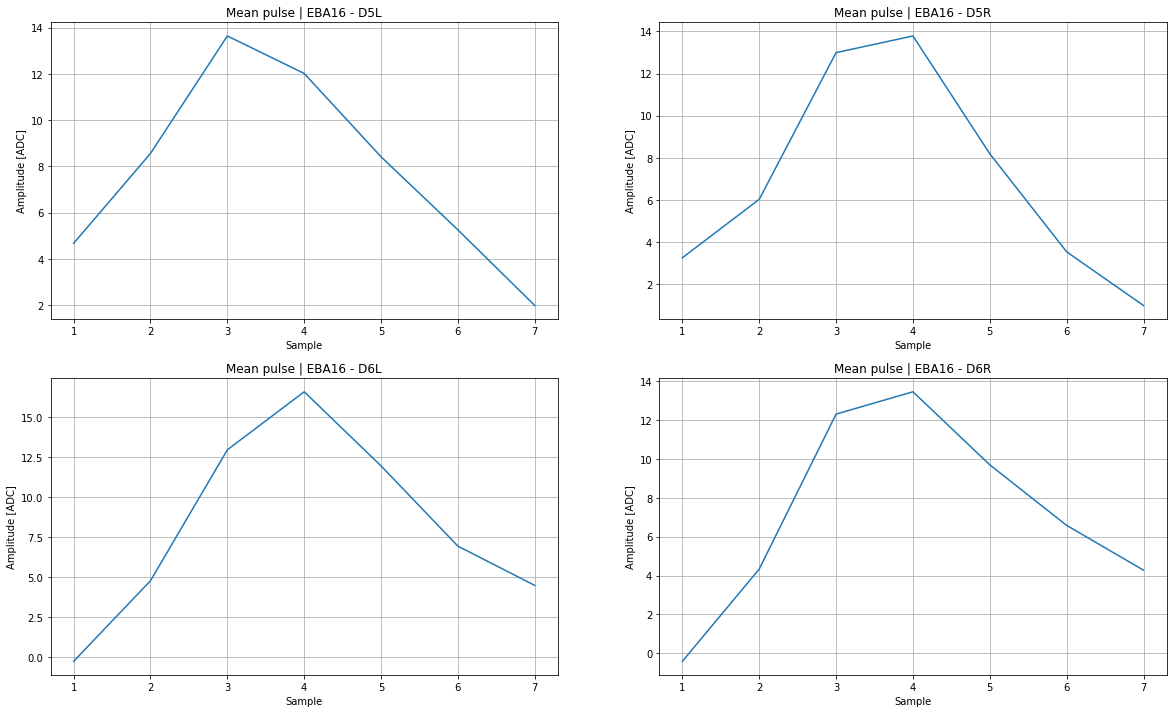

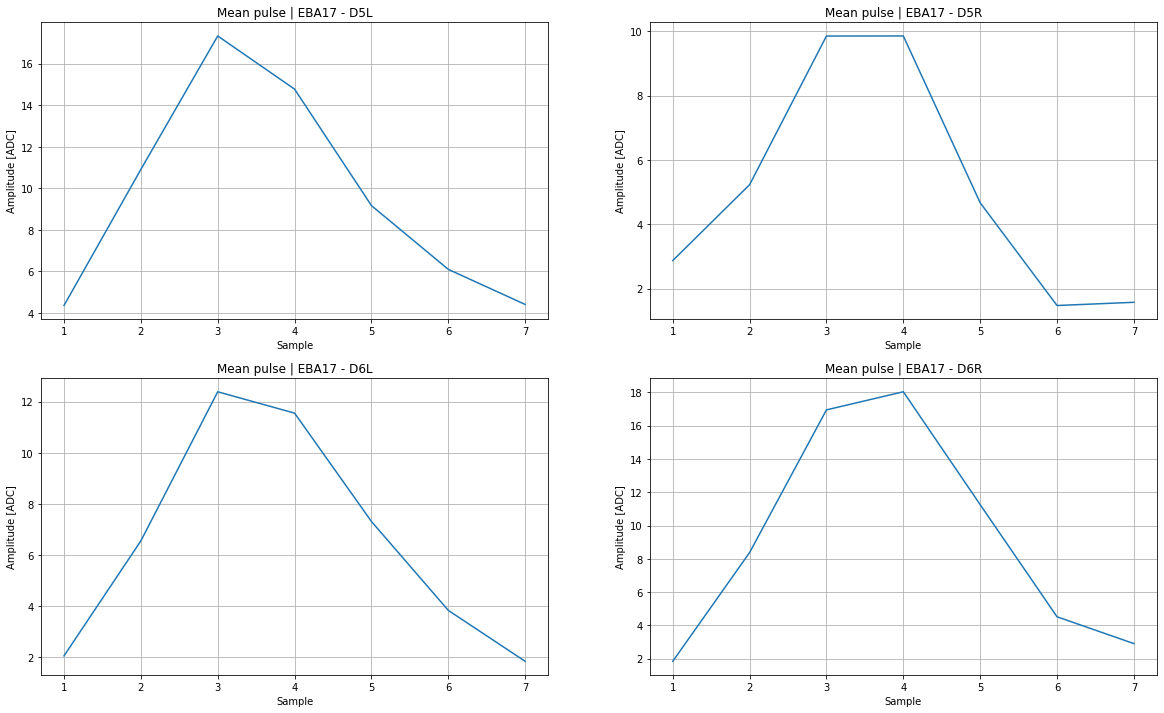

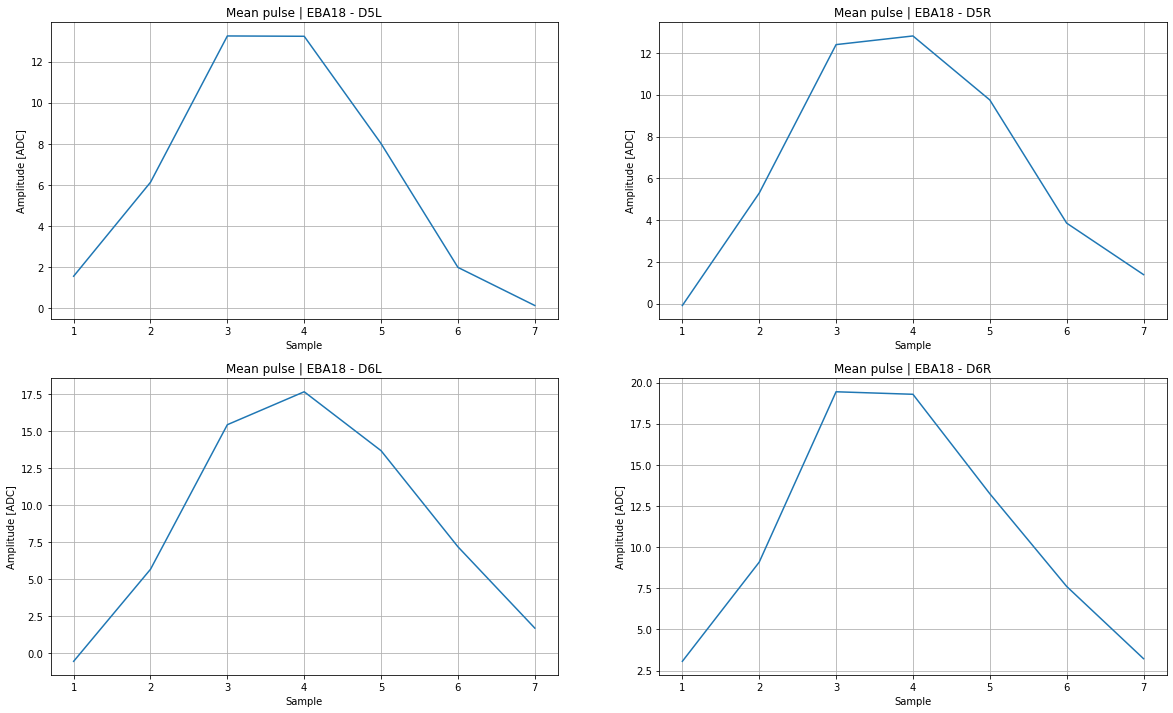

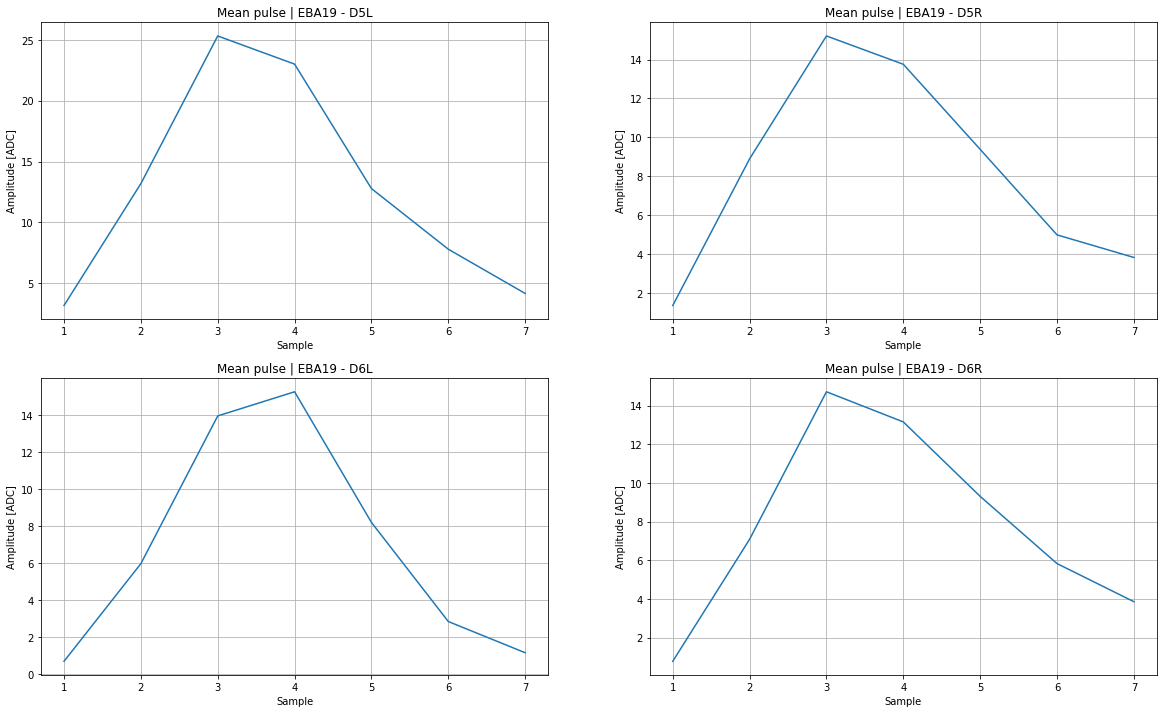

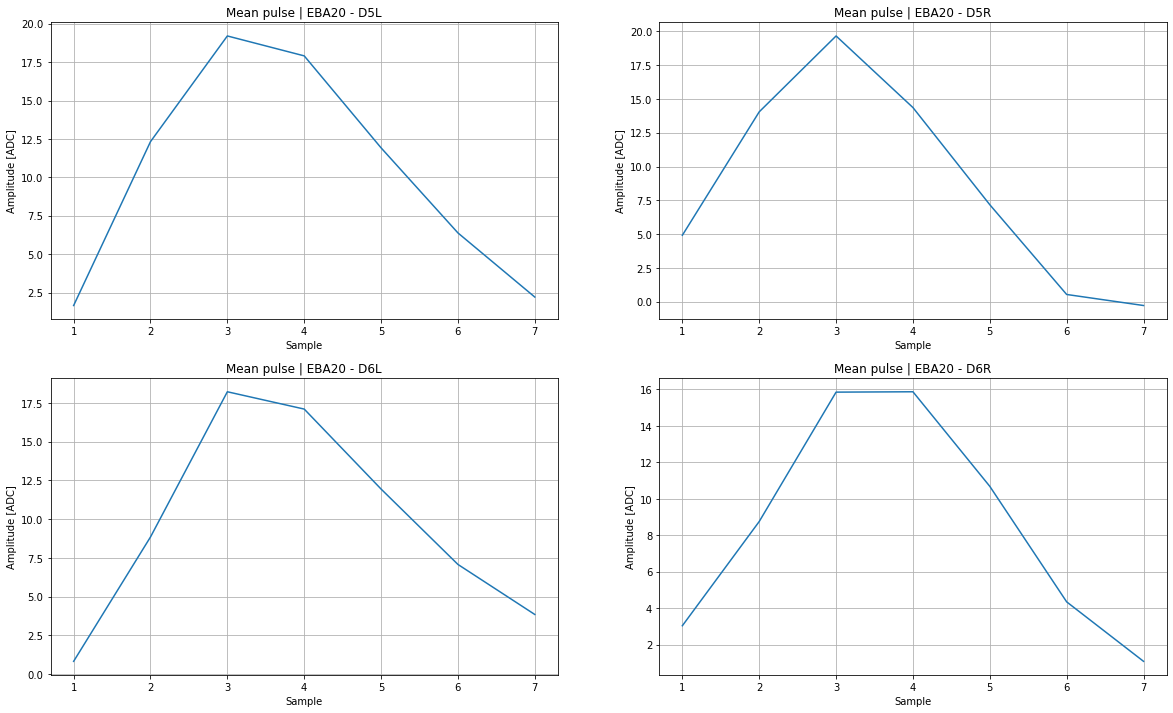

KeyboardInterrupt: 

In [8]:
if plotting == 1:
    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                plt.subplot(2,2,ch+1)
                plt.plot(pulses_axis, mean_pulse[sd,md,ch,:])
                plt.title("Mean pulse | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
                plt.xlabel("Sample")
                plt.ylabel("Amplitude [ADC]")
                plt.grid()
            output_path = plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path  + "/"             + sides_map.get(sd) + f"{md+1:02}" + "_mean_pulse.jpeg")
            plt.savefig(plots_path   + "/mean_pulse/"  + sides_map.get(sd) + f"{md+1:02}" + "_mean_pulse.jpeg")
            plt.close()


    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                plt.subplot(2,2,ch+1)
                plt.plot(pulses_axis, norm_pulse[sd,md,ch,:])
                plt.title("Normalized mean pulse | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
                plt.xlabel("Sample")
                plt.ylabel("Amplitude [ADC]")
                plt.grid()
            output_path = plots_path + "/all_modules/"     + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path  + "/"                 + sides_map.get(sd) + f"{md+1:02}" + "_mean_pulse_norm.jpeg")
            plt.savefig(plots_path   + "/mean_pulse_norm/" + sides_map.get(sd) + f"{md+1:02}" + "_mean_pulse_norm.jpeg")
            plt.close()

In [8]:
# for sd in sides_map:
#     for md in mods_map:
#         desc_str = "Processing " + sides_map.get(sd) + f"{md+1:02}" 
#         for ch in tqdm(cells_map, desc=desc_str):
#             if sd == 3 and md == 57:
#                 C[sd, md, ch,:,:] = np.cov(sampleZB[:, sd, md, ch, :].T)
#             else:
#                 C[sd, md, ch,:,:] = robust_cov(sampleZB[:, sd, md, ch, :].T)
#             #C[sd, md, ch,:,:] = np.cov(sampleZB[:, sd, md, ch, :].T)


In [9]:
# for sd in sides_map:
#     for md in range(58, 64):
#         desc_str = "Processing " + sides_map.get(sd) + f"{md+1:02}" 
#         for ch in tqdm(cells_map, desc=desc_str):
#             C[sd, md, ch,:,:] = robust_cov(sampleZB[:, sd, md, ch, :].T)
#             #C[sd, md, ch,:,:] = np.cov(sampleZB[:, sd, md, ch, :].T) 

#C = np.load('../data/data_' + run_number + '/'+ run_number + '_' + 'C.npy')
# np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'C.npy',C)



C = np.load('../data/robustcov100kevts_436422_C' + '.npy')

# solving matrix singular for problematic channels

C[3, 57, 0,:,:] = np.cov(sampleZB[:, 3, 57, 0, :].T)
C[3, 57, 1,:,:] = np.cov(sampleZB[:, 3, 57, 1, :].T)
C[3, 57, 2,:,:] = np.cov(sampleZB[:, 3, 57, 2, :].T)
C[3, 57, 3,:,:] = np.cov(sampleZB[:, 3, 57, 3, :].T)

C[2, 33, 0,:,:] = np.cov(sampleZB[:, 2, 33, 0, :].T)
C[3, 28, 1,:,:] = np.cov(sampleZB[:, 3, 28, 1, :].T)

In [10]:
if plotting == 1:
    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                plt.subplot(2,2,ch+1)
                sns.heatmap(C[sd, md, ch,:,:], annot=True, fmt='g')
                plt.title("Robust covariance matrix | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
                #plt.title("Covariance matrix | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
            output_path = plots_path + "/all_modules/"  + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path  + "/"              + sides_map.get(sd) + f"{md+1:02}" + "_covariance.jpeg")
            plt.savefig(plots_path   + "/covariance/"   + sides_map.get(sd) + f"{md+1:02}" + "_covariance.jpeg")
            plt.close()

In [11]:

for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            print("Processing " + sides_map.get(sd) + f"{md+1:02}" )
            C_inv[sd, md, ch,:,:] = np.linalg.inv(C[sd, md, ch,:,:])

Processing EBA01
Processing EBA01
Processing EBA01
Processing EBA01
Processing EBA02
Processing EBA02
Processing EBA02
Processing EBA02
Processing EBA03
Processing EBA03
Processing EBA03
Processing EBA03
Processing EBA04
Processing EBA04
Processing EBA04
Processing EBA04
Processing EBA05
Processing EBA05
Processing EBA05
Processing EBA05
Processing EBA06
Processing EBA06
Processing EBA06
Processing EBA06
Processing EBA07
Processing EBA07
Processing EBA07
Processing EBA07
Processing EBA08
Processing EBA08
Processing EBA08
Processing EBA08
Processing EBA09
Processing EBA09
Processing EBA09
Processing EBA09
Processing EBA10
Processing EBA10
Processing EBA10
Processing EBA10
Processing EBA11
Processing EBA11
Processing EBA11
Processing EBA11
Processing EBA12
Processing EBA12
Processing EBA12
Processing EBA12
Processing EBA13
Processing EBA13
Processing EBA13
Processing EBA13
Processing EBA14
Processing EBA14
Processing EBA14
Processing EBA14
Processing EBA15
Processing EBA15
Processing EBA

In [12]:
if plotting == 1:
    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                plt.subplot(2,2,ch+1)
                sns.heatmap(C_inv[sd, md, ch,:,:], annot=True, fmt='g')
                plt.title("Inverse covariance matrix | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
            output_path = plots_path + "/all_modules/"   + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path + "/"                + sides_map.get(sd) + f"{md+1:02}" + "_covariance_inv.jpeg")
            plt.savefig(plots_path  + "/covariance_inv/" + sides_map.get(sd) + f"{md+1:02}" + "_covariance_inv.jpeg")
            plt.close()

In [13]:
for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            h   = norm_pulse[sd,md,ch,:]
            num = np.dot(h, C_inv[sd, md, ch,:,:])
            den = (np.dot(num, h.T))
            w[sd,md,ch,:] = num/den


In [14]:
if plotting == 1:
    for sd in sides_map:
        for md in mods_map:
            plt.figure(figsize = (20, 12))
            for ch in cells_map:
                plt.subplot(2,2,ch+1)
                plt.plot(pulses_axis, w[sd,md,ch,:])
                plt.title("Weights | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
                plt.xlabel("Sample")
                plt.ylabel("Amplitude")
                plt.grid()
            output_path = plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}"
            plt.savefig(output_path  + "/"             + sides_map.get(sd) + f"{md+1:02}" + "_weights.jpeg")
            plt.savefig(plots_path   + "/weights/"     + sides_map.get(sd) + f"{md+1:02}" + "_weights.jpeg")
            plt.close()

In [15]:
# sampleMuonALL = np.concatenate((np.load("../files/muons4peak_436422/sampleMuon1000_436422.npy"), np.load("files/files_440716/samplePED_440716_0.npy")),axis=0)
# eOptMuonALL   = np.concatenate((np.load("../files/muons4peak_436422/eOptMuon1000_436422.npy"), np.zeros((200, 4, 64, 8, 1))),axis=0)
# #eOptMuonALL   = eOptMuonALL[0:200]
# #sampleMuonALL = sampleMuonALL[0:200]
# samples_ped = np.zeros((np.size(sampleMuonALL, 0), sides, modules, cells_in_use, samples))

# for evt in range(0, np.size(sampleMuonALL, 0)):
#     for sd in sides_map:
#         for md in mods_map:
#             for ch in cells_map:
#                 samples_ped[evt,sd,md,ch,:] = sampleMuonALL[evt,sd,md,ch,:] - pedestal[sd, md, ch, :]

                
# for sd in sides_map:
#     for md in mods_map:
#         p = [[], [] , [], []]
#         for evt in range(0, np.size(sampleMuonALL, 0)):
#             for ch in cells_map:
#                 p[ch].append(samples_ped[evt,sd,md,ch,:])

# for sd in sides_map:
#     for md in mods_map:
#         x = [[], [] , [], []]
#         y = [[], [] , [], []]
#         plt.figure(figsize = (20, 12))
#         for ch in cells_map:
#             for i in range(0, np.size(p[ch], axis=0)):
#                 x[ch].append(np.max(p[ch][i][:]))
#                 y[ch].append(np.dot(w[sd,md,ch,:],np.array(p[ch][i][:]).T))
#             plt.subplot(2,2,ch+1)
#             plt.plot(x[ch], y[ch], 'x')
#             plt.title("Fit | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
#             plt.xlabel("p")
#             plt.ylabel("w*p")
#             plt.grid()
#         output_path = plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}"
#         plt.savefig(output_path  + "/"             + sides_map.get(sd) + f"{md+1:02}" + "_filter.jpeg")
#         plt.savefig(plots_path   + "/filter/"      + sides_map.get(sd) + f"{md+1:02}" + "_filter.jpeg")
#         plt.close()

In [16]:
for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            for i in range(0, pulses):
                quant_w[sd,md,ch,i] = (w[sd,md,ch,i]/np.max(abs(w[sd,md,ch,:])))*511

quant_w   = quant_w.astype("int")

In [17]:
samplesPED = np.load("files/files_440716/samplePED_440716_0.npy")

for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            for i in range(0, pulses):
                quant_w[sd,md,ch,i] = (w[sd,md,ch,i]/np.max(abs(w[sd,md,ch,:])))*511

quant_w   = quant_w.astype("int")

ene    = np.zeros((sides, modules, cells_tmdb, 200))
ene_mean = np.zeros((sides, modules, cells_tmdb))
pedestal_fit = np.zeros((5000,4,64,8))

side          = {2: 'EBA', 3:'EBC'}                   # Side names

for sd in side:
    for md in range(0, modules):
        for ch in cells_map:
            for evt in range(0,200):
                ene[sd][md][ch][evt] = (np.dot(quant_w[sd,md,ch,:], samplesPED[evt,sd,md,ch,:]))
            ene_mean[sd][md][ch] = np.mean(ene[sd][md][ch])
            
#             label2 = "eTMDB [" + str("{:.3f}".format(float(ene_mean[sd][md][ch]))) + "ADC]"
        
#             plt.hist(ene[sd][md][ch], alpha=0.6, label=label2)
#             plt.legend(loc='upper right')

#             title = str(side.get(sd)) + f"{md+1:02}" + " " + str(channel.get(ch))
#             plt.title(title)
#             plt.xlabel('Energy [ADC]')
#             plt.ylabel('Entries')

#             plt.show()
for sd in side:
    for md in range(0, modules):
        for ch in cells_map:       
            for evt in range(0,5000):
                pedestal_fit[evt][sd][md][ch] = ene_mean[sd][md][ch]


In [18]:
# sampleMuonALL = np.load("../files/muons4peak_436422/sampleMuon1000_436422.npy")
# print(sampleMuonALL.shape)
# print(pedestal_fit.shape)

In [19]:

# sampleMuonALL = np.concatenate((np.load("../files/muons4peak_436422/sampleMuon1000_436422.npy"), np.load("files/files_440716/samplePED_440716_0.npy")),axis=0)
# eOptMuonALL   = np.concatenate((np.load("../files/muons4peak_436422/eOptMuon1000_436422.npy"), np.zeros((200, 4, 64, 8, 1))),axis=0)

sampleMuonALL = np.load('../files/muons4peak_' + run_number + '/sampleMuon'+ n_muons_file + '_' + run_number + '.npy')
eOptMuonALL   = np.load('../files/muons4peak_' + run_number + '/eOptMuon' + n_muons_file   + '_' + run_number + '.npy')
sampleMuonALL = sampleMuonALL[0:n_muons]
eOptMuonALL   = eOptMuonALL[0:n_muons]

eOptPedestal = np.zeros((5000, 4, 64, 8, 1))

coefit      = np.zeros((sides, modules, cells_in_use, 2))

for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            for i in range(0, pulses):
                quant_w[sd,md,ch,i] = (w[sd,md,ch,i]/np.max(abs(w[sd,md,ch,:])))*511

quant_w   = quant_w.astype("int")

for sd in sides_map:
    for md in mods_map:
        plt.figure(figsize = (20, 12))
        xq        = [[], [] , [], []]
        yq        = [[], [] , [], []]
        coef      = [[], [] , [], []]
        poly1d_fn = [[], [] , [], []]
        for ch in cells_map:
            for evt in range(0, np.size(sampleMuonALL, 0)):
                if max(sampleMuonALL[evt,sd,md,ch,:]) != 0:
                    if eOptMuonALL[evt,sd,md,ch,0] > 500:
                        xq[ch].append(np.dot(quant_w[sd,md,ch,:], sampleMuonALL[evt,sd,md,ch,:]))
                        yq[ch].append(eOptMuonALL[evt,sd,md,ch,0])
            for evt in range(0, 5000):
                xq[ch].append(pedestal_fit[evt,sd,md,ch])
                yq[ch].append(eOptPedestal[evt,sd,md,ch,0])
        for ch in cells_map:
            coef[ch]       = np.polyfit(xq[ch],yq[ch],1)
            poly1d_fn[ch]  = np.poly1d(coef[ch])
            e500[sd,md,ch] = (threshold - coef[ch][1])/coef[ch][0]
            coefit[sd,md,ch,0] = coef[ch][0]
            coefit[sd,md,ch,1] = coef[ch][1]

            plt.subplot(2,2,ch+1)
            plt.plot(xq[ch], yq[ch], '*', xq[ch], poly1d_fn[ch](xq[ch]))
            plt.plot(e500[sd,md,ch], threshold, "mD")
            plt.title("Fit | " + sides_map.get(sd) + f"{md+1:02}" + " - " + channel.get(ch))
            plt.ylabel('Energy [MeV]')
            plt.xlabel('Filter Output')
            plt.grid()
        output_path = plots_path + "/all_modules/" + sides_map.get(sd) + f"{md+1:02}"
        plt.savefig(output_path  + "/"             + sides_map.get(sd) + f"{md+1:02}" +  "_fit.jpeg")
        plt.savefig(plots_path   + "/fit/"         + sides_map.get(sd) + f"{md+1:02}" + "_fit.jpeg")
        plt.close()

In [20]:
print(std_relat[3,8,0])

0.0


In [21]:
# print('D5R    ', e500[0])
# print('D5L    ', e500[1])
# print('D6R    ', e500[2])
# print('D6R    ', e500[3])

# print('D5sum  ', e500[0]+e500[1])
# print('D6sum  ', e500[2]+e500[3])
# print('D56sum ', sum(e500))

# # criar np.array(sides, modules, cells, ¨?¨)

In [22]:
std_relat = np.zeros((sides, modules,               7))
old_std   = np.zeros((sides, modules,               7))
new_std   = np.zeros((sides, modules,               7))

sampleZB   = np.concatenate((np.load('files/files_427892/sampleZB_427892_0.npy'), np.load('files/files_427892/sampleZB_427892_1.npy')),axis=0)
#D5L
n=0
m=0
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, m, 2])
            aux_dot = np.dot(w[sd, md, m], (sampleZB[i, sd, md, m, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]


#D5R
n=1
m=1
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, m, 2])
            aux_dot = np.dot(w[sd, md, m], (sampleZB[i, sd, md, m, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]

#D6L
n=2
m=2
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, m, 2])
            aux_dot = np.dot(w[sd, md, m], (sampleZB[i, sd, md, m, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]


#D6R
n=3
m=3
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, m, 2])
            aux_dot = np.dot(w[sd, md, m], (sampleZB[i, sd, md, m, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]

#D5
n=4
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, 0, 2] + sampleZB[i, sd, md, 1, 2])
            aux_dot = np.dot(w[sd, md, 0], (sampleZB[i, sd, md, 0, :].T)) + np.dot(w[sd, md, 1], (sampleZB[i, sd, md, 1, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]

#D6
n=5
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, 2, 2] + sampleZB[i, sd, md, 3, 2])
            aux_dot = np.dot(w[sd, md, 2], (sampleZB[i, sd, md, 2, :].T)) + np.dot(w[sd, md, 3], (sampleZB[i, sd, md, 3, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]
        
#D56
n=6
for sd in sides_map:
    for md in mods_map:
        zb  = []
        wzb = []
        for i in range(0, entries):
            zb.append(sampleZB[i, sd, md, 0, 2] + sampleZB[i, sd, md, 1, 2] + sampleZB[i, sd, md, 2, 2] + sampleZB[i, sd, md, 3, 2])
            aux_dot = np.dot(w[sd, md, 0], (sampleZB[i, sd, md, 0, :].T)) + np.dot(w[sd, md, 1], (sampleZB[i, sd, md, 1, :].T)) + np.dot(w[sd, md, 2], (sampleZB[i, sd, md, 2, :].T)) + np.dot(w[sd, md, 3], (sampleZB[i, sd, md, 3, :].T))
            wzb.append(aux_dot)
        old_std[sd,md,n]   = np.std(zb)
        new_std[sd,md,n]   = np.std(wzb)
        std_relat[sd,md,n] = (new_std[sd,md,n]-old_std[sd,md,n])/old_std[sd,md,n]

/tmp/ipykernel_2991/1549100279.py:75: RuntimeWarning: overflow encountered in ubyte_scalars
  zb.append(sampleZB[i, sd, md, 0, 2] + sampleZB[i, sd, md, 1, 2])
/tmp/ipykernel_2991/1549100279.py:103: RuntimeWarning: overflow encountered in ubyte_scalars
  zb.append(sampleZB[i, sd, md, 0, 2] + sampleZB[i, sd, md, 1, 2] + sampleZB[i, sd, md, 2, 2] + sampleZB[i, sd, md, 3, 2])


In [23]:
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'mean_pulse.npy',   mean_pulse)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'norm_pulse.npy',   norm_pulse)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'pedestal.npy',       pedestal)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'samples_ped.npy', samples_ped)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'C.npy',                     C)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'C_inv.npy',             C_inv)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'w.npy',                     w)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'quant_w.npy',         quant_w)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'std_relat.npy',     std_relat)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'e500_ch.npy',            e500)
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'coefit.npy',           coefit)

In [24]:
for sd in sides_map:
    for md in mods_map:
        print(sides_map.get(sd) + f"{md+1:02}")
        print("D5L: ",100*std_relat[sd,md,0])
        print("D5R: ",100*std_relat[sd,md,1])
        
        print("\nD5:  ",100*std_relat[sd,md,4])
        
        print("\nD6L: ",100*std_relat[sd,md,2])
        print("D6R: ",100*std_relat[sd,md,3])
        
        print("\nD6:  ",100*std_relat[sd,md,5])
        
        print("\nD56: ",100*std_relat[sd,md,6])
        
        
        print("\n\n")

EBA01
D5L:  -8.485281049531528
D5R:  -6.712081942272411

D5:   -7.741100742622034

D6L:  -4.2180206181654345
D6R:  -3.775318457542076

D6:   -4.46683846396306

D56:  -6.344025515641091



EBA02
D5L:  -9.557829962138511
D5R:  -6.4330463870743255

D5:   -7.922529030123149

D6L:  -4.52243536537929
D6R:  -5.829007554616822

D6:   -5.490437756239559

D56:  -7.432541870796716



EBA03
D5L:  -9.103030924584294
D5R:  -12.001446210622543

D5:   -9.990947497374856

D6L:  -9.073251936504077
D6R:  -10.716544381188404

D6:   -11.138215547195058

D56:  -9.8450310884045



EBA04
D5L:  -6.935425567072427
D5R:  -7.516513360234393

D5:   -7.352120847678447

D6L:  -5.978893252542609
D6R:  -8.841647495192177

D6:   -7.227878647736195

D56:  -7.736451743559739



EBA05
D5L:  -8.467624903499237
D5R:  -5.46906587252581

D5:   -7.0331248008607625

D6L:  -11.126945723842502
D6R:  -9.656028903172974

D6:   -10.746449029655667

D56:  -7.943866873839518



EBA06
D5L:  -4.164872140242346
D5R:  -11.655707206480262


In [25]:
for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            print(sides_map.get(sd) + f"{md+1:02}" + " " + str(ch) + " 0 " + str(int(e500[sd,md,ch])))

EBA01 0 0 25000
EBA01 1 0 28785
EBA01 2 0 22796
EBA01 3 0 36204
EBA02 0 0 21777
EBA02 1 0 27477
EBA02 2 0 29558
EBA02 3 0 29925
EBA03 0 0 22318
EBA03 1 0 23453
EBA03 2 0 31835
EBA03 3 0 27909
EBA04 0 0 18847
EBA04 1 0 30370
EBA04 2 0 29618
EBA04 3 0 27832
EBA05 0 0 21520
EBA05 1 0 21798
EBA05 2 0 23747
EBA05 3 0 28835
EBA06 0 0 26715
EBA06 1 0 19786
EBA06 2 0 22924
EBA06 3 0 27157
EBA07 0 0 30042
EBA07 1 0 25822
EBA07 2 0 14549
EBA07 3 0 24120
EBA08 0 0 36168
EBA08 1 0 21373
EBA08 2 0 25654
EBA08 3 0 27483
EBA09 0 0 37873
EBA09 1 0 30029
EBA09 2 0 29317
EBA09 3 0 28793
EBA10 0 0 26749
EBA10 1 0 35635
EBA10 2 0 30642
EBA10 3 0 24231
EBA11 0 0 31938
EBA11 1 0 41577
EBA11 2 0 25528
EBA11 3 0 20007
EBA12 0 0 23404
EBA12 1 0 21393
EBA12 2 0 22759
EBA12 3 0 23689
EBA13 0 0 14473
EBA13 1 0 22456
EBA13 2 0 27227
EBA13 3 0 19270
EBA14 0 0 32976
EBA14 1 0 19490
EBA14 2 0 29660
EBA14 3 0 28315
EBA15 0 0 12820
EBA15 1 0 25345
EBA15 2 0 27829
EBA15 3 0 40089
EBA16 0 0 23303
EBA16 1 0 28959
EBA16 2 

In [26]:
# for sd in sides_map:
#     for md in mods_map:
#         for ch in cells_map:
#             print(sides_map.get(sd) + f"{md+1:02}" + " " + str(ch) + " 0 " + str(np.flip(quant_w[sd,md,ch])))

In [27]:
# print('D5sum  ', e500[0]+e500[1])
# print('D6sum  ', e500[2]+e500[3])
# print('D56sum ', sum(e500))

In [28]:
# threshold files

#e500=np.load('../data/data_' + run_number + '/'+ run_number + '_' + 'e500.npy')

# 0 for the off channels
# e500[3,57,0] = 0
# e500[3,57,1] = 0
# e500[3,57,2] = 0
# e500[3,57,3] = 0
#duplicate the good channel when their pair is bad: EBA 6, 34, 61, 63, EBC 6

for sd in sides_map:
    for md in mods_map:
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "0" + " 0 " + str(int(e500[sd,md,0]+e500[sd,md,1])))
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "1" + " 0 " + str(int(e500[sd,md,2]+e500[sd,md,3])))
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "2" + " 0 " + str(int(sum(e500[sd,md,:]))))
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "3" + " 0 " + "0")

EBA01 0 0 53785
EBA01 1 0 59000
EBA01 2 0 112786
EBA01 3 0 0
EBA02 0 0 49255
EBA02 1 0 59483
EBA02 2 0 108739
EBA02 3 0 0
EBA03 0 0 45772
EBA03 1 0 59745
EBA03 2 0 105517
EBA03 3 0 0
EBA04 0 0 49217
EBA04 1 0 57450
EBA04 2 0 106668
EBA04 3 0 0
EBA05 0 0 43319
EBA05 1 0 52583
EBA05 2 0 95903
EBA05 3 0 0
EBA06 0 0 46502
EBA06 1 0 50082
EBA06 2 0 96584
EBA06 3 0 0
EBA07 0 0 55865
EBA07 1 0 38670
EBA07 2 0 94535
EBA07 3 0 0
EBA08 0 0 57541
EBA08 1 0 53138
EBA08 2 0 110680
EBA08 3 0 0
EBA09 0 0 67903
EBA09 1 0 58111
EBA09 2 0 126014
EBA09 3 0 0
EBA10 0 0 62385
EBA10 1 0 54873
EBA10 2 0 117258
EBA10 3 0 0
EBA11 0 0 73515
EBA11 1 0 45536
EBA11 2 0 119051
EBA11 3 0 0
EBA12 0 0 44798
EBA12 1 0 46448
EBA12 2 0 91247
EBA12 3 0 0
EBA13 0 0 36930
EBA13 1 0 46497
EBA13 2 0 83428
EBA13 3 0 0
EBA14 0 0 52466
EBA14 1 0 57975
EBA14 2 0 110441
EBA14 3 0 0
EBA15 0 0 38165
EBA15 1 0 67919
EBA15 2 0 106084
EBA15 3 0 0
EBA16 0 0 52263
EBA16 1 0 45365
EBA16 2 0 97628
EBA16 3 0 0
EBA17 0 0 51898
EBA17 1 0 5798

In [29]:
for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            print(sides_map.get(sd) + f"{md+1:02}" + "  " + str(ch) + " 0    " + str("{:.6f}".format(float(coefit[sd,md,ch, 0]))) + "    " + str("{:.6f}".format(float(coefit[sd,md,ch, 1]))))

EBA01  0 0    0.075892    -1397.311734
EBA01  1 0    0.061109    -1259.082021
EBA01  2 0    0.077397    -1264.383368
EBA01  3 0    0.059012    -1636.479025
EBA02  0 0    0.084548    -1341.257716
EBA02  1 0    0.056672    -1057.227186
EBA02  2 0    0.067428    -1493.035886
EBA02  3 0    0.063796    -1409.110671
EBA03  0 0    0.076827    -1214.702189
EBA03  1 0    0.074322    -1243.074641
EBA03  2 0    0.059063    -1380.335852
EBA03  3 0    0.073022    -1537.984112
EBA04  0 0    0.087071    -1141.056283
EBA04  1 0    0.054493    -1154.965981
EBA04  2 0    0.066760    -1477.329250
EBA04  3 0    0.064596    -1297.856801
EBA05  0 0    0.080288    -1227.827632
EBA05  1 0    0.084815    -1348.879365
EBA05  2 0    0.075018    -1281.518301
EBA05  3 0    0.067579    -1448.707089
EBA06  0 0    0.058307    -1057.693517
EBA06  1 0    0.078207    -1047.476063
EBA06  2 0    1.451331    -32771.207765
EBA06  3 0    0.064872    -1261.761866
EBA07  0 0    0.063597    -1410.630116
EBA07  1 0    0.061482  

In [30]:
#"PESOS NO FORMATO DO COOL DB W6,W5,W4,W3,W2,W1,W0
for sd in sides_map:
    for md in mods_map:
        for ch in cells_map:
            #print(sides_map.get(sd) + f"{md+1:02}" + " " + str(ch) + " 0 " + str(np.flip(quant_w[sd,md,ch])))
            print(sides_map.get(sd) + f"{md+1:02}" + " " + str(ch) + " 0 " + str(quant_w[sd,md,ch,6])+ " " + str(quant_w[sd,md,ch,5])+ " " + str(quant_w[sd,md,ch,4])+ " " + str(quant_w[sd,md,ch,3])+ " " + str(quant_w[sd,md,ch,2])+ " " + str(quant_w[sd,md,ch,1])+ " " + str(quant_w[sd,md,ch,0]))

EBA01 0 0 91 -28 40 -31 336 511 -328
EBA01 1 0 -67 20 117 16 445 511 -413
EBA01 2 0 -153 125 -70 76 511 200 -192
EBA01 3 0 118 -130 -6 187 511 398 -256
EBA02 0 0 -30 42 49 146 511 -138 -83
EBA02 1 0 75 -181 165 511 425 -246 -171
EBA02 2 0 -86 210 95 511 156 -71 -103
EBA02 3 0 -12 37 5 511 506 -469 115
EBA03 0 0 -5 -55 121 168 511 -154 -74
EBA03 1 0 -240 403 -227 394 511 -239 -135
EBA03 2 0 127 -191 246 -49 494 511 -410
EBA03 3 0 -132 225 38 173 511 -67 -100
EBA04 0 0 -17 67 -48 90 511 -15 -157
EBA04 1 0 -49 118 -82 444 511 -19 -198
EBA04 2 0 14 212 -108 511 412 -371 71
EBA04 3 0 -60 60 145 294 511 -248 -72
EBA05 0 0 -174 115 -32 234 511 -142 -26
EBA05 1 0 -109 150 21 42 511 -31 -104
EBA05 2 0 80 -4 -116 319 204 511 -422
EBA05 3 0 182 -141 78 -66 454 511 -327
EBA06 0 0 -56 75 32 397 511 -227 -101
EBA06 1 0 20 11 30 171 511 -152 -141
EBA06 2 0 -35 -246 16 79 126 511 311
EBA06 3 0 163 -144 72 -39 511 428 -342
EBA07 0 0 -34 82 164 137 511 184 -321
EBA07 1 0 -138 99 150 227 511 85 -373
EBA0

In [31]:
os.system("mkdir " + plots_path +             "/fit_LR")

for sd in sides_map:
    for md in mods_map:
        plt.figure(figsize = (20, 8))
        xq        = [[], []]
        yq        = [[], []]
        coef      = [[], []]
        poly1d_fn = [[], []]
        for evt in range(0, np.size(sampleMuonALL, 0)):
            xq[0].append(np.dot(quant_w[sd,md,0,:], sampleMuonALL[evt,sd,md,0,:]) + np.dot(quant_w[sd,md,1,:], sampleMuonALL[evt,sd,md,1,:]))
            yq[0].append(eOptMuonALL[evt,sd,md,0,0] + eOptMuonALL[evt,sd,md,1,0])
            
            xq[1].append(np.dot(quant_w[sd,md,2,:], sampleMuonALL[evt,sd,md,2,:]) + np.dot(quant_w[sd,md,3,:], sampleMuonALL[evt,sd,md,3,:]))
            yq[1].append(eOptMuonALL[evt,sd,md,2,0] + eOptMuonALL[evt,sd,md,3,0])
            
        for evt in range(0, 5000):
            xq[0].append(pedestal_fit[evt,sd,md,0] + pedestal_fit[evt,sd,md,1])
            yq[0].append(0)

            xq[1].append(pedestal_fit[evt,sd,md,2] + pedestal_fit[evt,sd,md,3])
            yq[1].append(0)
                
        ch = 0
        coef[ch]       = np.polyfit(xq[ch],yq[ch],1)
        poly1d_fn[ch]  = np.poly1d(coef[ch])
        e500[sd,md,ch] = (threshold - coef[ch][1])/coef[ch][0]
        coefit[sd,md,ch,0] = coef[ch][0]
        coefit[sd,md,ch,1] = coef[ch][1]

        plt.subplot(1,2,1)
        plt.plot(xq[ch], yq[ch], '*', xq[ch], poly1d_fn[ch](xq[ch]))
        plt.plot(e500[sd,md,ch], threshold, "mD")
        plt.title("Fit | " + sides_map.get(sd) + f"{md+1:02}" + " - D5")
        plt.ylabel('Energy [MeV]')
        plt.xlabel('Filter Output')
        plt.grid()
                             
        ch = 1
        coef[ch]       = np.polyfit(xq[ch],yq[ch],1)
        poly1d_fn[ch]  = np.poly1d(coef[ch])
        e500[sd,md,ch] = (threshold - coef[ch][1])/coef[ch][0]
        coefit[sd,md,ch,0] = coef[ch][0]
        coefit[sd,md,ch,1] = coef[ch][1]
        
        plt.subplot(1,2,2)
        plt.plot(xq[ch], yq[ch], '*', xq[ch], poly1d_fn[ch](xq[ch]))
        plt.plot(e500[sd,md,ch], threshold, "mD")
        plt.title("Fit | " + sides_map.get(sd) + f"{md+1:02}" + " - D6")
        plt.ylabel('Energy [MeV]')
        plt.xlabel('Filter Output')
        plt.grid()
                             
#         plt.show()
        
        plt.savefig(plots_path   + "/fit_LR/"         + sides_map.get(sd) + f"{md+1:02}" + "_fit.jpeg")
        plt.close()

mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/fit_LR’: File exists


In [32]:
os.system("mkdir " + plots_path +             "/fit_D56")

for sd in sides_map:
    for md in mods_map:
        plt.figure(figsize = (10, 8))
        xq        = [[]]
        yq        = [[]]
        coef      = [[]]
        poly1d_fn = [[]]
        for evt in range(0, np.size(sampleMuonALL, 0)):
            xq[0].append(np.dot(quant_w[sd,md,0,:], sampleMuonALL[evt,sd,md,0,:]) + np.dot(quant_w[sd,md,1,:], sampleMuonALL[evt,sd,md,1,:]) + np.dot(quant_w[sd,md,2,:], sampleMuonALL[evt,sd,md,2,:]) + np.dot(quant_w[sd,md,3,:], sampleMuonALL[evt,sd,md,3,:]))
            yq[0].append(eOptMuonALL[evt,sd,md,0,0] + eOptMuonALL[evt,sd,md,1,0] + eOptMuonALL[evt,sd,md,2,0] + eOptMuonALL[evt,sd,md,3,0])
            
            
        for evt in range(0, 5000):
            xq[0].append(pedestal_fit[evt,sd,md,0] + pedestal_fit[evt,sd,md,1] + pedestal_fit[evt,sd,md,2] + pedestal_fit[evt,sd,md,3])
            yq[0].append(0)

        e500[sd,md,3] = 0
        
        ch = 2
        coef[0]       = np.polyfit(xq[0],yq[0],1)
        poly1d_fn[0]  = np.poly1d(coef[0])
        e500[sd,md,ch] = (threshold - coef[0][1])/coef[0][0]
        coefit[sd,md,ch,0] = coef[0][0]
        coefit[sd,md,ch,1] = coef[0][1]

        plt.plot(xq[0], yq[0], '*', xq[0], poly1d_fn[0](xq[0]))
        plt.plot(e500[sd,md,ch], threshold, "mD")
        plt.title("Fit | " + sides_map.get(sd) + f"{md+1:02}" + " - D56")
        plt.ylabel('Energy [MeV]')
        plt.xlabel('Filter Output')
        plt.grid()
                             
        plt.savefig(plots_path   + "/fit_D56/"         + sides_map.get(sd) + f"{md+1:02}" + "_fit.jpeg")
        plt.close()

mkdir: cannot create directory ‘../plots/plots_451896_robust_cov/fit_D56’: File exists


In [33]:
np.save('../data/data_' + run_number + '/'+ run_number + '_' + 'e500_sums.npy',               e500)

for sd in sides_map:
    for md in mods_map:
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "0" + " 0 " + str(int(e500[sd,md,0])))
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "1" + " 0 " + str(int(e500[sd,md,1])))
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "2" + " 0 " + str(int(e500[sd,md,2])))
        print(sides_map.get(sd) + f"{md+1:02}" + " " + "3" + " 0 " + "0")

EBA01 0 0 46392
EBA01 1 0 51528
EBA01 2 0 90499
EBA01 3 0 0
EBA02 0 0 41871
EBA02 1 0 51811
EBA02 2 0 86218
EBA02 3 0 0
EBA03 0 0 39126
EBA03 1 0 52063
EBA03 2 0 84068
EBA03 3 0 0
EBA04 0 0 41730
EBA04 1 0 49792
EBA04 2 0 84021
EBA04 3 0 0
EBA05 0 0 37230
EBA05 1 0 45483
EBA05 2 0 76215
EBA05 3 0 0
EBA06 0 0 38980
EBA06 1 0 46302
EBA06 2 0 79380
EBA06 3 0 0
EBA07 0 0 47826
EBA07 1 0 33390
EBA07 2 0 74647
EBA07 3 0 0
EBA08 0 0 51125
EBA08 1 0 46363
EBA08 2 0 90955
EBA08 3 0 0
EBA09 0 0 59214
EBA09 1 0 51425
EBA09 2 0 103079
EBA09 3 0 0
EBA10 0 0 53399
EBA10 1 0 48603
EBA10 2 0 94513
EBA10 3 0 0
EBA11 0 0 64402
EBA11 1 0 39345
EBA11 2 0 96312
EBA11 3 0 0
EBA12 0 0 38291
EBA12 1 0 39674
EBA12 2 0 71416
EBA12 3 0 0
EBA13 0 0 31601
EBA13 1 0 39557
EBA13 2 0 65100
EBA13 3 0 0
EBA14 0 0 45857
EBA14 1 0 50101
EBA14 2 0 88742
EBA14 3 0 0
EBA15 0 0 33386
EBA15 1 0 59986
EBA15 2 0 87004
EBA15 3 0 0
EBA16 0 0 45566
EBA16 1 0 38680
EBA16 2 0 77632
EBA16 3 0 0
EBA17 0 0 45591
EBA17 1 0 50808
EBA17 2